In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.rcsetup import cycler
from os.path import abspath, dirname, join
import scipy.sparse as sp


from openTSNE import TSNE
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

from tqdm import tqdm
import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs, lang2large_family

figure_dir = "fig/typology"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [167]:
model = 'xlm'
exps = pd.read_table(f"../dataframes/{model}_exps.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

exps = add_probing_location_better_column(exps)
exps['probing_location_better'][exps.perturbation=='next1'] = True
exps['probing_location_better'][exps.perturbation=='next2'] = True
exps['perturbation'][exps.perturbation=='mBERT-rand-subw'] = 'rand-subw'

/tmp/ipykernel_16942/3791307714.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['probing_location_better'][exps.perturbation=='next1'] = True
/tmp/ipykernel_16942/3791307714.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['probing_location_better'][exps.perturbation=='next2'] = True
/tmp/ipykernel_16942/3791307714.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['perturbation'][exps.perturbation=='mBERT-rand

In [168]:
exps

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,family,probing_location_better
0,XLM-RoBERTa,Afrikaans,number_noun,B$_2$,first,0.855000,0.850000,number,noun,Afrikaans number_noun,Germanic,False
1,XLM-RoBERTa,Afrikaans,number_noun,B$_2$,last,0.965000,0.971429,number,noun,Afrikaans number_noun,Germanic,True
2,XLM-RoBERTa,Afrikaans,number_noun,L$_2$,first,0.872857,0.862143,number,noun,Afrikaans number_noun,Germanic,False
3,XLM-RoBERTa,Afrikaans,number_noun,L$_2$,last,0.966429,0.979286,number,noun,Afrikaans number_noun,Germanic,True
4,XLM-RoBERTa,Afrikaans,number_noun,R$_2$,first,0.881429,0.842143,number,noun,Afrikaans number_noun,Germanic,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5881,XLM-RoBERTa,Urdu,number_noun,permute,last,0.964286,0.907143,number,noun,Urdu number_noun,Indic,True
5882,XLM-RoBERTa,Urdu,number_noun,prev1,last,0.949286,0.874286,number,noun,Urdu number_noun,Indic,True
5883,XLM-RoBERTa,Urdu,number_noun,prev2,last,0.887857,0.786429,number,noun,Urdu number_noun,Indic,True
5884,XLM-RoBERTa,Urdu,number_noun,NaN,first,0.935714,0.902857,number,noun,Urdu number_noun,Indic,False


In [169]:
#fertility = pd.read_table("../dataframes/task_fertility.tsv")
#old_len = len(exps)

#exps = exps.merge(fertility, on=['language', 'task'], how='inner')

#if old_len != len(exps):
#    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Perturbations

In [170]:
data_perturbations = ['TARG','L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [
    'prev1',
    'next1',
    #'prev2',
    #'next2',
    'rand-subw',
]
baseline_models = []

# Test effect

$$
\text{Effect}(p, t) = 100(1 - \frac{\text{Acc}(p, t)}{\text{Acc}(t)})
$$

In [171]:
bert_exps = exps[
    (exps.model=='XLM-RoBERTa') &
    (exps.probing_location_better==True)
]

bert_exps.shape

(3569, 12)

In [172]:
bert_exps.groupby(['language', 'task', 'perturbation'], dropna=False).size().value_counts()

1    3569
dtype: int64

In [173]:
unperturbed = bert_exps[bert_exps.perturbation.isnull()]
unperturbed = unperturbed.set_index(['language', 'task']).test_acc

In [174]:
perturbed = bert_exps[bert_exps.perturbation.isin(model_perturbations + data_perturbations)].pivot_table(
    index=['language', 'task'], columns='perturbation', values='test_acc'
)

In [175]:
test_effect = 100 * (1 - perturbed / unperturbed.values[:, None])

In [176]:
#test_effect.plot.box(rot=80,showfliers=False).get_figure().savefig(f"{figure_dir}/mbert-mean-std.pdf", bbox_inches="tight")

<AxesSubplot:xlabel='perturbation'>

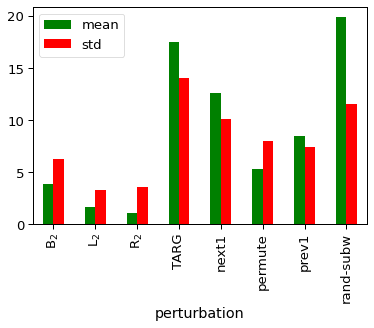

In [12]:
test_effect.agg([np.mean, np.std]).pivot_table(columns=['mean','std']).plot(kind='bar',color=['green','red'])

In [68]:
test_effect.mean()

perturbation
B$_2$         3.478948
L$_2$         1.232405
R$_2$         0.794370
TARG         13.845774
next1         9.848978
permute       5.155282
prev1         9.854908
rand-subw    19.483970
dtype: float64

# Linguistic typology

## Logistic regression (classification) using WALS features

In [177]:
areas = pd.read_csv("../dataframes/wals/wals_areas.tsv", sep="\t")
feat2area = dict(areas[['Name', 'Area']].drop_duplicates().values)
feat2area['Family'] = 'Family'

wals_languages = []
wals = []
param2area = {}
for fn in os.listdir('../dataframes/wals'):
    if not fn.endswith('csv'):
        continue
    lang = fn.split(".")[0]
    wals_languages.append(lang)
    df = pd.read_csv(f"../dataframes/wals/{lang}.csv", encoding='latin1')
    df = df.sort_values('Parameter').pivot(index='Language', columns='Parameter', values='Name')
    wals.append(df)
    
wals = pd.concat(wals, sort=True)
wals.index = wals_languages
wals.loc['Latin'] = np.nan 
wals['Family'] = wals.index.map(lambda l: lang2family[l])
print(wals.shape), wals.isnull().stack().mean()

(39, 177)


/tmp/ipykernel_16942/722615636.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  wals['Family'] = wals.index.map(lambda l: lang2family[l])


(None, 0.4632768361581921)

In [178]:
te = test_effect[model_perturbations + data_perturbations].copy()
te['HAS_TASK'] = 1
logreg_perts = te.columns
te = te.unstack()
te = te.fillna(0)
te['HAS_TASK'] = te['HAS_TASK'].fillna(0)

In [15]:
lin_acc = []
K = 3

for col in wals.columns:
    target = wals[col].dropna()
    common = sorted(set(target.index) & set(te.index))
    label_cnt = target.value_counts()
    large_classes = label_cnt[label_cnt>=K]
    if len(large_classes) < 2:
        continue
    target = target[target.isin(large_classes.index)]
    if target.value_counts(normalize=True).max() > 0.8:
         continue
    if len(label_cnt) < 2:
        continue
    te_common = te.loc[target.index]
    for pert in logreg_perts:
        X = te_common[pert]
        score = cross_val_score(
            LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
            X, target, cv=3, scoring='f1_macro')
        notnull = len(target)
        lin_acc.append({
            'perturbation': pert, 'feature': col, 'score': score.mean(),
            'notnull': notnull, 'labels': dict(target.value_counts())})
    X = te_common
    score = cross_val_score(
        LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
        X, target, cv=3, scoring='f1_macro')
    notnull = len(target)
    lin_acc.append({'perturbation': 'ALL', 'feature': col, 'score': score.mean(),
                    'notnull': notnull, 'labels': dict(target.value_counts())})
lin_acc = pd.DataFrame(lin_acc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [72]:
pd.set_option('display.max_rows', 500)
l = lin_acc.sort_values('score', ascending=False).copy()

In [73]:
l.perturbation = l.perturbation.str.replace('$', '')
l['Area'] = l.feature.apply(lambda l: feat2area[l])
l.head(15)

/tmp/ipykernel_11503/2209059831.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  l.perturbation = l.perturbation.str.replace('$', '')


,perturbation,feature,score,notnull,labels,Area
739,ALL,Systems of Gender Assignment,0.933333,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
737,permute,Systems of Gender Assignment,0.933333,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
316,B_2,Numeral Classifiers,0.920635,15,"{'Absent': 12, 'Optional': 3}",Nominal Categories
589,ALL,Reciprocal Constructions,0.920635,15,"{'Mixed': 9, 'Distinct from reflexive': 6}",Simple Clauses
118,HAS_TASK,Distributive Numerals,0.878307,19,"{'Marked by preceding word': 11, 'No distribut...",Nominal Categories
667,permute,Sex-based and Non-sex-based Gender Systems,0.876190,16,"{'Sex-based': 10, 'No gender': 6}",Nominal Categories
119,ALL,Distributive Numerals,0.868783,19,"{'Marked by preceding word': 11, 'No distribut...",Nominal Categories
732,rand-subw,Systems of Gender Assignment,0.866667,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
665,R_2,Sex-based and Non-sex-based Gender Systems,0.863492,16,"{'Sex-based': 10, 'No gender': 6}",Nominal Categories
900,prev1,Family,0.863095,27,"{'Slavic': 9, 'Germanic': 8, 'Romance': 7, 'Ur...",Family


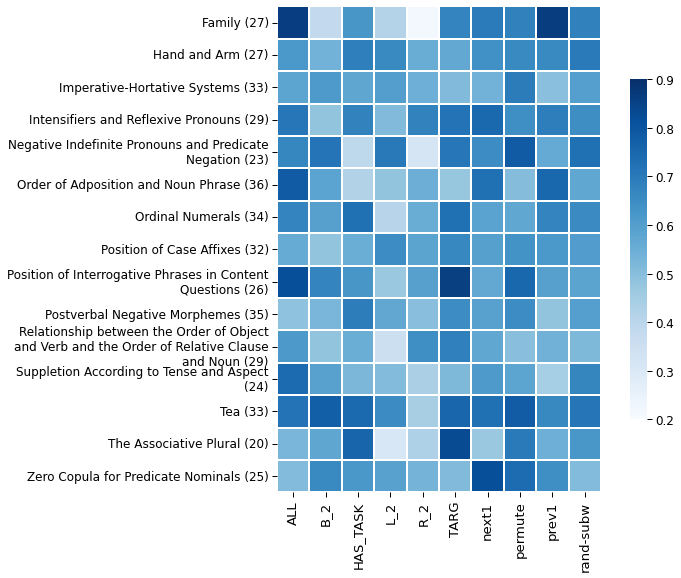

In [74]:
features = set(l[l['notnull']>=20].groupby('feature').score.mean().sort_values(ascending=False).head(15).index)

def wrap_text(text, maxline=40):
    lines = []
    this_line = []
    for word in text.split(" "):
        this_line.append(word)
        if sum(len(w) + 1 for w in this_line) - 1 >= maxline:
            lines.append(" ".join(this_line))
            this_line = []
    if this_line:
        lines.append(" ".join(this_line))
    return "\n".join(lines)
        
def plot_wals_pert_heatmap(data, save_fn=None, title=None):
    notnull = data[['feature', 'notnull']].drop_duplicates().set_index('feature')['notnull']
    table = data.pivot(index='feature', columns='perturbation', values='score')
    ysize = max(len(table), 6)
    max_text_len = data['feature'].str.len().max()
    scale = 'small' if max_text_len >= 85 else 'large'
    with matplotlib.rc_context(rc={'ytick.labelsize': 'large'}):
        fig, ax = plt.subplots(1, figsize=(12, 8))
        sns.heatmap(table, cmap='Blues', ax=ax, linewidth=.1, square=True, cbar_kws={'shrink': 0.7}, vmax=0.9, vmin=0.2)
        ticks = []
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            t = "{} ({})".format(t, notnull.loc[t])
            tick.set_text(wrap_text(t))
            ticks.append(tick)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.subplots_adjust(left=0.5)
        plt.tight_layout()
        if title:
            ax.set_title(title)
        if save_fn:
            fig.savefig(save_fn, format='eps')
plot_wals_pert_heatmap(l[l.feature.isin(features)], save_fn=f"{figure_dir}/{model}_heatmap_wals_logreg.eps")

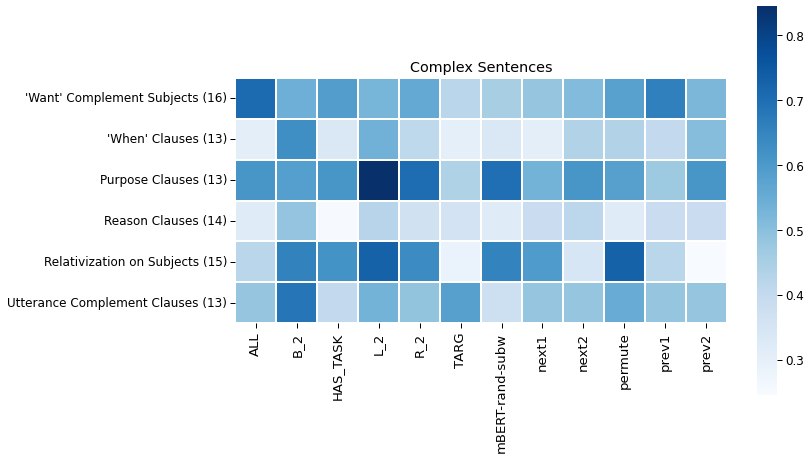

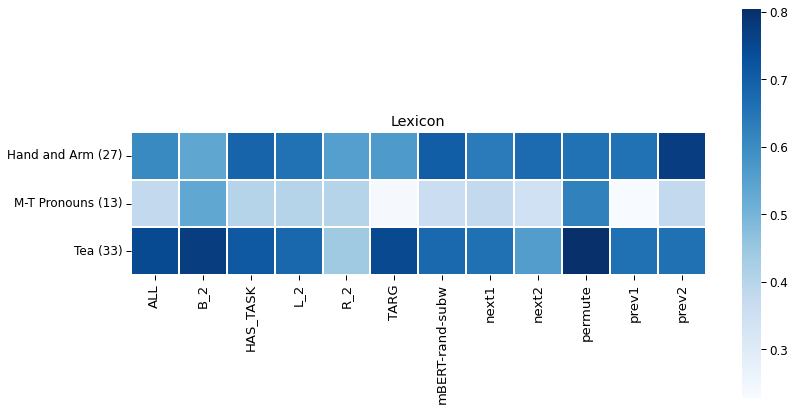

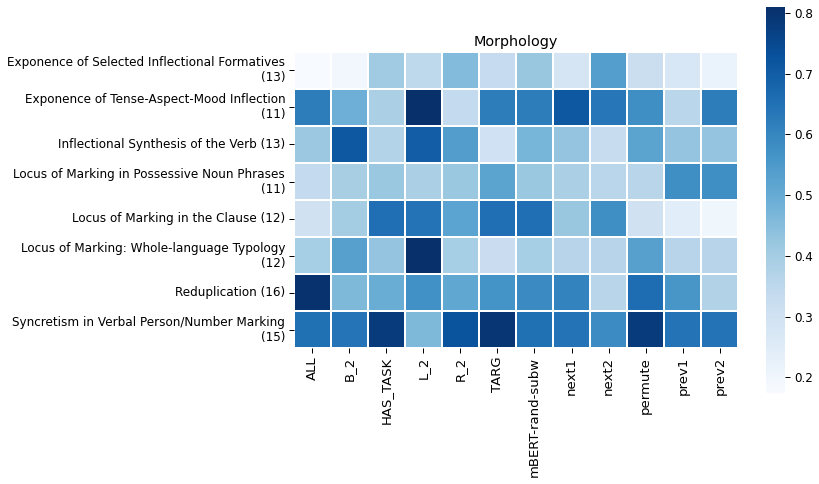

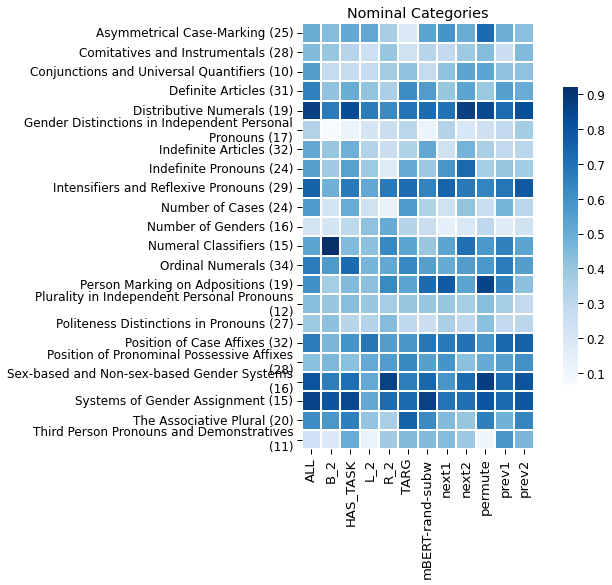

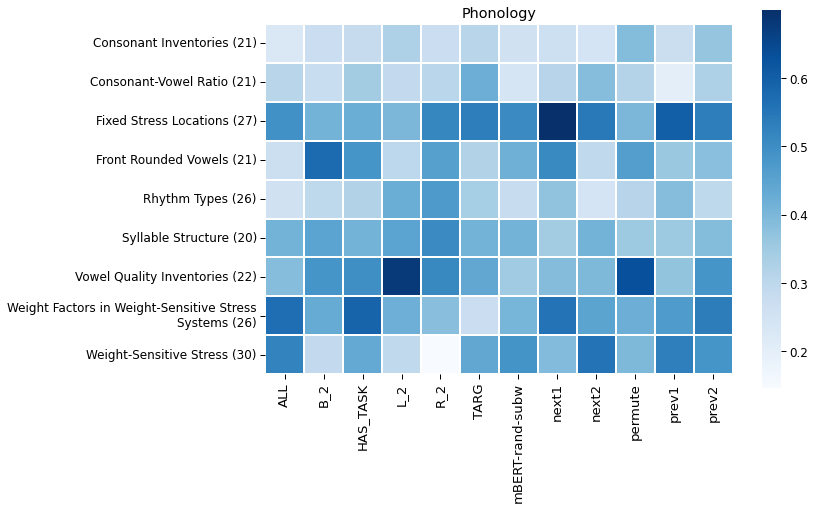

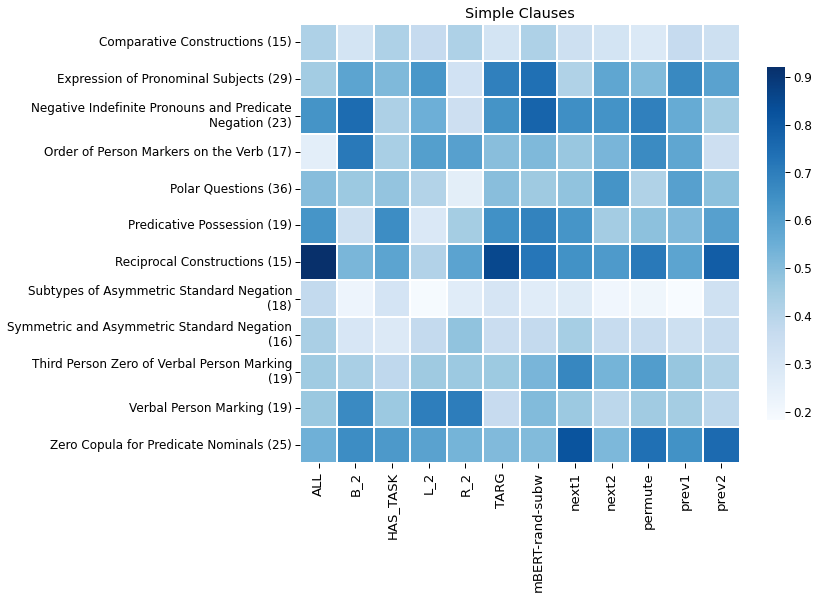

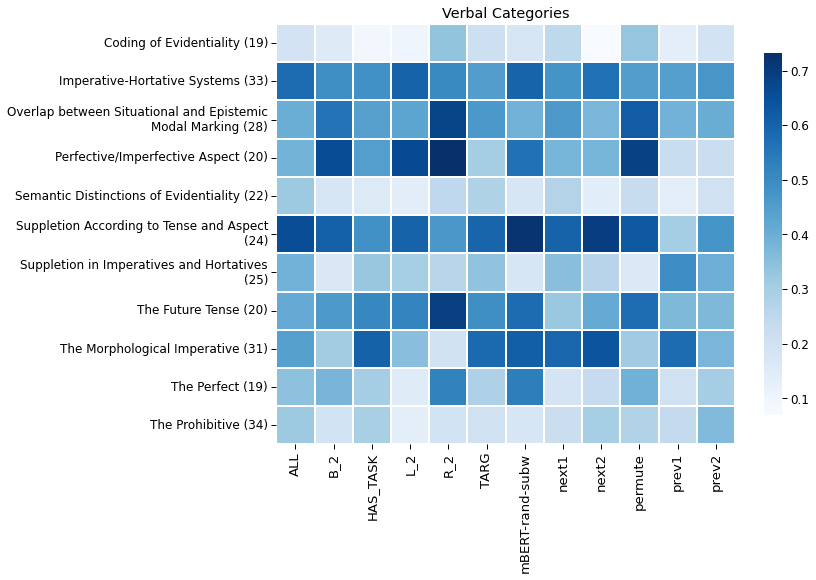

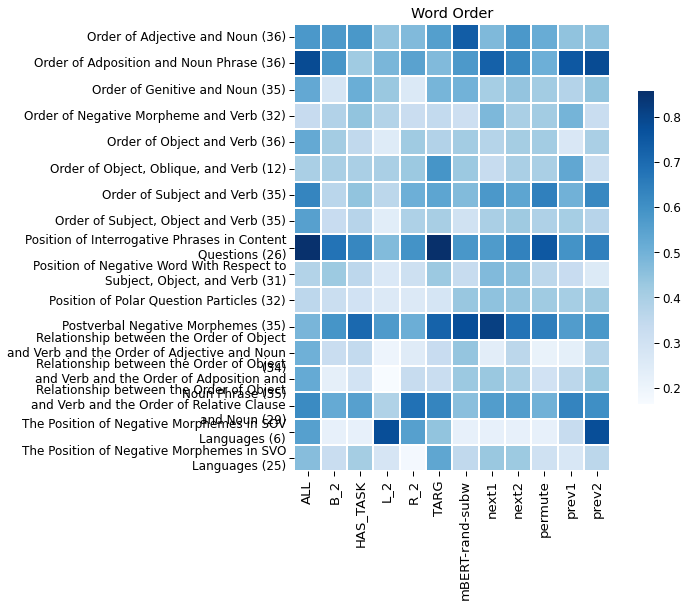

In [82]:
for area, group in l.groupby('Area'):
    if group.feature.nunique() < 2:
        continue
    area_name = area.replace(' ', '_').lower()
    plot_wals_pert_heatmap(group, title=area, save_fn=f"{figure_dir}/heatmap_wals_{area_name}.png")

## Linear regression weights

Target: effect of each perturbations

In [17]:
lin_acc = []
K = 3

linreg_scores = []

for pert in model_perturbations + data_perturbations:
    target = test_effect[pert].mean(level=0)
    target = target.drop('Latin')
    features = pd.get_dummies(wals.drop('Latin').fillna('Nan'))
    score = cross_val_score(
        SVR(),
        features, target, cv=3, scoring='neg_root_mean_squared_error')
    linreg_scores.append({'perturbation': pert, 'score': score.mean()})
linreg_scores = pd.DataFrame(linreg_scores)

/tmp/ipykernel_16942/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_16942/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_16942/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_16942/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is depr

In [18]:
linreg_scores

,perturbation,score
0,prev1,-2.920841
1,next1,-4.368867
2,rand-subw,-5.203874
3,TARG,-7.927509
4,L$_2$,-1.347578
5,R$_2$,-2.374257
6,B$_2$,-3.914581
7,permute,-5.065792


## Family aggregated mean/std

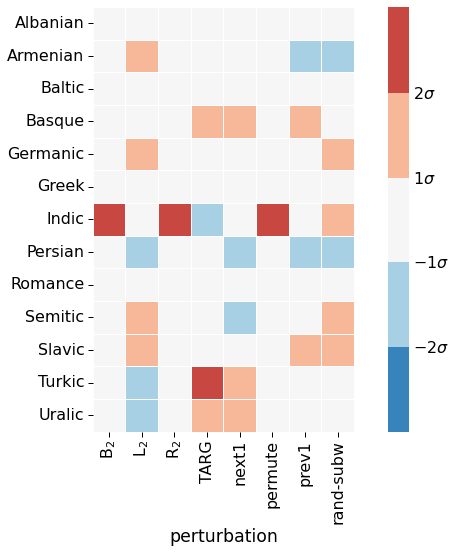

In [19]:
te = test_effect.reset_index()
te['family'] = te.language.apply(lambda l: lang2family[l])
te = te.groupby('family').mean()
te_std = te.std()
te_mean = te.mean()

te_discrete = pd.cut(((te - te_mean) / te_std).stack(), bins=[-1000, -2, -1, 1, 2, 1000], labels=[-2, -1, 0, 1, 2]).unstack().astype(int)
te_discrete
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    sns.heatmap(te_discrete, ax=ax, cmap=sns.color_palette('RdBu_r', 5),
                linewidths=.5, vmin=-2, vmax=2, center=0, square=True)
    ax.set_ylabel("")
    colorbar = ax.collections[0].colorbar
    #colorbar.ax.set_frame_on(True)
    colorbar.ax.tick_params(size=0)
    ticklabels = [
        "$-2\sigma$",
        "$-1\sigma$",
        "$1\sigma$",
        "$2\sigma$",
    ]
    u = 2 / 2.5
    colorbar.set_ticks([-1.5*u, -0.5*u, 0.5*u, 1.5*u])
    colorbar.set_ticklabels(ticklabels)
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/heatmap_family_effect_std_bin.pdf", bbox_inches='tight')

## Clustering

In [22]:
def do_cluster(K):
    #d = unfiltered['test_effect'][keep_perturbations]
    X = test_effect.pivot_table(index='language', columns='task')
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K, n_init=5)
    k.fit(X)
    clusters = [[] for _ in range(K)]
    for i, lab in enumerate(k.labels_):
        clusters[lab].append(X.index[i])
    print(f"K = {K}")
    print("\n------\n".join(", ".join(cl) for cl in clusters))
    
do_cluster(5)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


K = 5
Croatian, Czech, Latin, Polish, Russian, Serbian, Slovak, Slovenian, Ukrainian
------
Estonian, Finnish, Hungarian
------
Albanian, Arabic, Bulgarian, Catalan, Dutch, French, Greek, Hindi, Italian, Portuguese, Romanian, Spanish, Urdu
------
Afrikaans, Armenian, Basque, Danish, English, Hebrew, Latvian, Lithuanian, Norwegian_Bokmal, Norwegian_Nynorsk, Persian, Swedish, Turkish
------
German


In [77]:
from sklearn.metrics import pairwise_distances_argmin

def kmeans(X, n_clusters, metric='chebyshev'):
    # 1. Randomly choose clusters
    rseed = np.random.randint(500000)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers, metric=metric)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return labels

## Chebyshev kmeans

In [179]:
cooc = defaultdict(lambda: defaultdict(int))
metric = 'chebyshev'

def increase_cooc(langs):
    for l1 in langs:
        for l2 in langs:
            cooc[l1][l2] += 1
            
for _ in tqdm(range(100)):
    K = np.random.randint(4, 9)
    X = test_effect.pivot_table(index='language', columns='task')[model_perturbations + data_perturbations]
    X = X.fillna(X.mean())
    #X = test_effect.pivot_table(index='language', columns='task')
    #value = np.random.normal(loc=X.mean(), scale=X.std(ddof=0), size=(39,328))
    #stdfilled_df = pd.DataFrame(value, index=X.index, columns=X.columns)
    #X = X.fillna(stdfilled_df)
    labels = kmeans(X.to_numpy(), n_clusters=K, metric=metric) # chebyshev, sqeuclidean, minkowski, cosine, manhattan
    cl = pd.DataFrame({'language': X.index, 'cluster':labels})
    cl.groupby('cluster').language.apply(increase_cooc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.48it/s]


In [180]:
l = exps[['family', 'language']].drop_duplicates().sort_values(['family', 'language'])
l['code'] = l.language.apply(lambda l: lang2code[l])
e = exps[['language']].drop_duplicates()
e['family'] = e['language'].apply(lambda l: lang2large_family[l])
family_size = e.family.value_counts().sort_index()

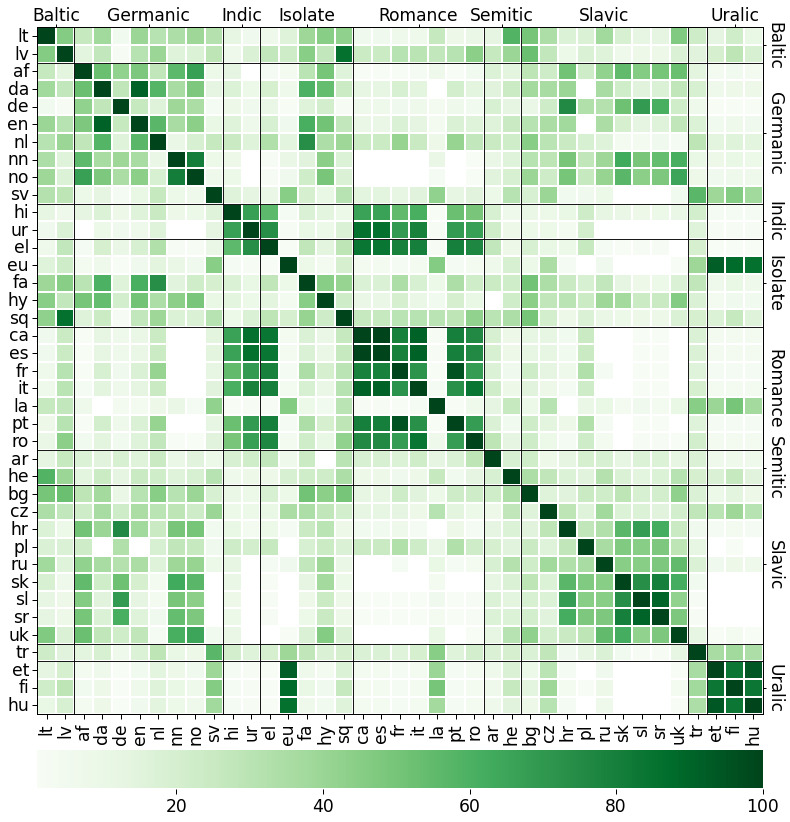

In [181]:
ticklabels = []
ticklocs = []
lang_family = exps[['language']].drop_duplicates()
lang_family['family'] = lang_family['language'].apply(lambda l: lang2large_family[l])
lang_family['code'] = lang_family['language'].apply(lambda l: lang2code[l])
family_size = lang_family.family.value_counts().sort_index()

for fi, (family, size) in enumerate(family_size.items()):
    if size > 1:
        ticklabels.append(family)
        start = family_size.iloc[:fi].sum()
        if fi < len(e) - 1:
            end = family_size.iloc[:fi+1].sum()
        else:
            end = family_size.sum()
        loc = (start+end) / 2
        ticklocs.append(loc)

lang_order = lang_family.sort_values(['family', 'code'])

with sns.plotting_context('paper', font_scale=1.95):
    grid_kws = {"height_ratios": (.9, .05), "hspace": .1}

    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(13, 14))
    data = pd.DataFrame(cooc).loc[lang_order.language][lang_order.language]
    data.columns = [lang2code[c] for c in data.columns]
    data.index = [lang2code[c] for c in data.index]
    sns.heatmap(data, ax=ax, cmap='Greens', cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, linewidths=.1)
    for f in np.cumsum(family_size)[:-1]:
        ax.plot((f, f), (0, data.shape[0]), c='black', linewidth=.9)
        ax.plot((0, data.shape[1]), (f, f), c='black', linewidth=.9)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax2 = ax.twiny()
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(ticklabels)
    ax2.tick_params(axis='x', which='major', pad=0, length=3)
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(ax.get_xlim())
    
    ax3 = ax.twinx()
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(ticklabels, va='center')
    ax3.tick_params(axis='y', rotation=-90, which='major', pad=0, length=3)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylim(ax.get_ylim())
    
    fig.savefig(f"{figure_dir}/{model}_heatmap_langlang_cluster_{metric}_cooc.eps", format='eps')

In [182]:
cooc = defaultdict(lambda: defaultdict(int))

def increase_cooc(langs):
    for l1 in langs:
        for l2 in langs:
            cooc[l1][l2] += 1
            
for _ in range(100):
    K = np.random.randint(4, 9)
    X = test_effect.pivot_table(index='language', columns='task')[model_perturbations + data_perturbations]
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K)
    k.fit(X)
    cl = pd.DataFrame({'language': X.index, 'cluster':k.labels_})
    cl.groupby('cluster').language.apply(increase_cooc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [183]:
l = exps[['family', 'language']].drop_duplicates().sort_values(['family', 'language'])
l['code'] = l.language.apply(lambda l: lang2code[l])

In [184]:
e = exps[['language']].drop_duplicates()
e['family'] = e['language'].apply(lambda l: lang2large_family[l])
family_size = e.family.value_counts().sort_index()

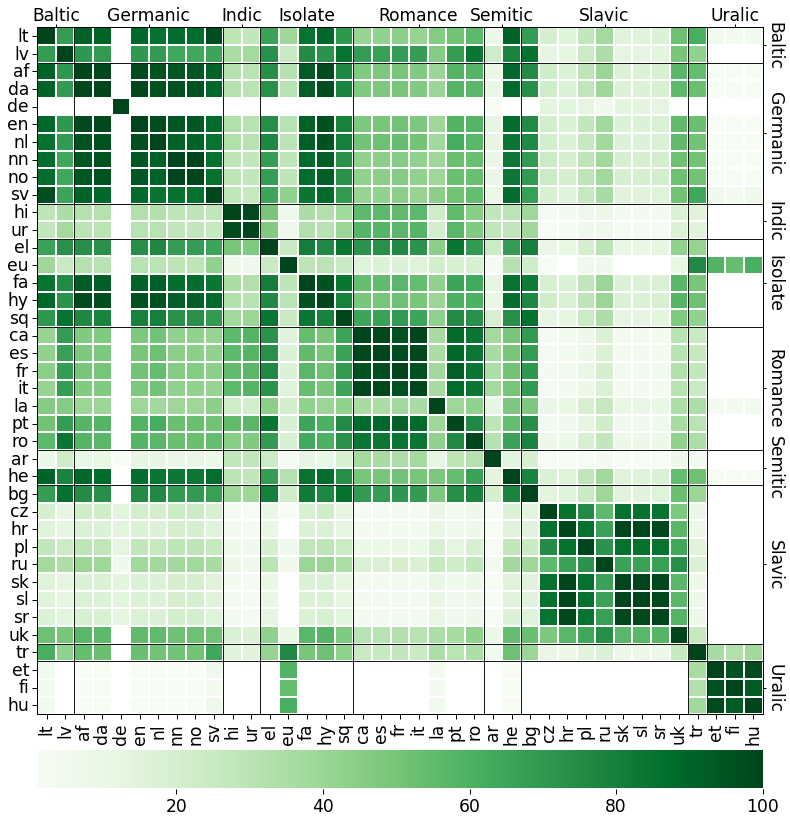

In [185]:
ticklabels = []
ticklocs = []
lang_family = exps[['language']].drop_duplicates()
lang_family['family'] = lang_family['language'].apply(lambda l: lang2large_family[l])
lang_family['code'] = lang_family['language'].apply(lambda l: lang2code[l])
family_size = lang_family.family.value_counts().sort_index()

for fi, (family, size) in enumerate(family_size.items()):
    if size > 1:
        ticklabels.append(family)
        start = family_size.iloc[:fi].sum()
        if fi < len(e) - 1:
            end = family_size.iloc[:fi+1].sum()
        else:
            end = family_size.sum()
        loc = (start+end) / 2
        ticklocs.append(loc)
        
lang_order = lang_family.sort_values(['family', 'code'])

with sns.plotting_context('paper', font_scale=1.95):
    grid_kws = {"height_ratios": (.9, .05), "hspace": .1}

    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(13, 14))
    data = pd.DataFrame(cooc).loc[lang_order.language][lang_order.language]
    data.columns = [lang2code[c] for c in data.columns]
    data.index = [lang2code[c] for c in data.index]
    sns.heatmap(data, ax=ax, cmap='Greens', cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, linewidths=.1)
    for f in np.cumsum(family_size)[:-1]:
        ax.plot((f, f), (0, data.shape[0]), c='black', linewidth=.9)
        ax.plot((0, data.shape[1]), (f, f), c='black', linewidth=.9)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax2 = ax.twiny()
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(ticklabels)
    ax2.tick_params(axis='x', which='major', pad=0, length=3)
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(ax.get_xlim())
    
    ax3 = ax.twinx()
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(ticklabels, va='center')
    ax3.tick_params(axis='y', rotation=-90, which='major', pad=0, length=3)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylim(ax.get_ylim())
    
    fig.savefig(f"{figure_dir}/{model}_scikit_heatmap_langlang_cluster_cooc.eps",format='eps')

In [25]:
def plot(x, y,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    fig, ax = matplotlib.pyplot.subplots(1, figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 1), "s": kwargs.get("s", 100)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
        
    default_colors = cycler(color=['#2f4f4f','#7f0000','#191970','#008000',
                                        '#ff8c00','#00ff00','#00ffff','#0000ff','#ff00ff','#eee8aa','#dda0dd', '#a52a2a',
                                        '#ff1493','#a020f0', '#f08080', '#adff2f', '#ff7f50', '#ff00ff', '#1e90ff', '#f0e68c', '#dda0dd',
                                       '#00ced1', '#ff8c00',  '#00fa9a', '#dc143c', '#00bfff', '#0000ff',
                                       '#808080', '#556b2f', '#a0522d', '#006400', '#8b0000', '#808000', '#483d8b', '#3cb371',
                                       '#008080', '#4682b4', '#000080', '#32cd32', '#daa520', '#800080', '#b03060', '#ff0000',
                                       ])
    colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=False, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        #ax.scatter(
        #    centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        #)

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 1.0,
                    label,
                    fontsize=kwargs.get("fontsize", 10),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")
    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(-0.17, 0.75), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)
    fig.savefig(f"{figure_dir}/{model}_tsne_plot.eps", format='eps')

In [61]:
#átlagolva az effektek
X = test_effect.pivot_table(index='language', columns='task')
X = X.fillna(pd.DataFrame(np.random.normal(loc=X.mean(), scale=X.std(ddof=0), size=(39,328)), index=X.index, columns=X.columns)).stack().groupby('language').mean()

In [345]:
#test_effect.groupby('language').mean()

In [33]:
#X = test_effect.groupby('language').mean().to_numpy()
y_lang = test_effect.index.get_level_values('language').drop_duplicates().to_numpy()
y_family = test_effect.index.get_level_values('language').drop_duplicates().to_numpy()
for i, a in enumerate(y_family):
    y_family[i] = lang2family[a]

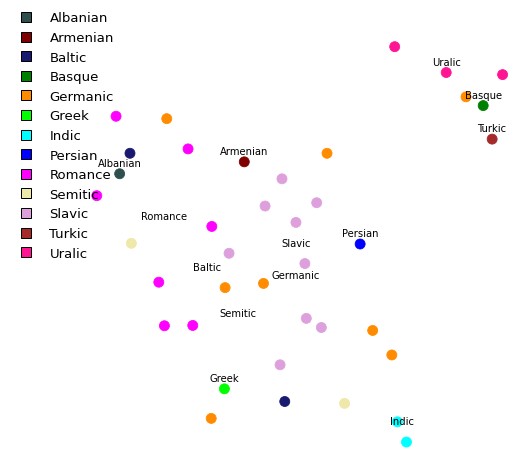

In [76]:
# szórással tölti ki
X = test_effect.pivot_table(index='language', columns='task')
value = np.random.normal(loc=X.mean(), scale=X.std(ddof=0), size=(39,328))
stdfilled_df = pd.DataFrame(value, index=X.index, columns=X.columns)
X = X.fillna(stdfilled_df).to_numpy()
tsne = TSNE(
    perplexity=3,
    metric="euclidean",
    n_jobs=100,
    random_state=42,
    verbose=False,
)
embedding_train = tsne.fit(X)
plot(embedding_train, y_family, draw_centers=True, draw_cluster_labels=True)

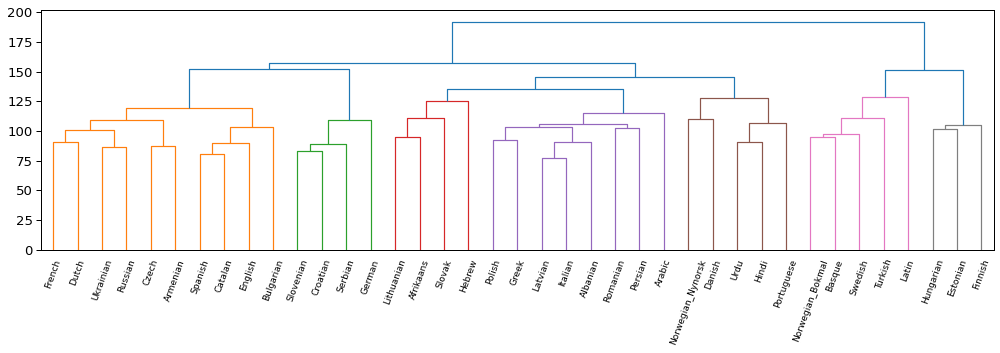

In [210]:
X = test_effect.pivot_table(index='language', columns='task')
value = np.random.normal(loc=X.mean(), scale=X.std(ddof=0), size=(39,324))
stdfilled_df = pd.DataFrame(value, index=X.index, columns=X.columns)
X = X.fillna(stdfilled_df).to_numpy()

linked = linkage(X, 'ward')

labelList = y_lang
plt.figure(figsize=(14, 5))
dendrogram(linked,
            orientation='top',
            labels=labelList,
           leaf_rotation=70,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=9.,)
plt.tight_layout()
plt.savefig(f'{figure_dir}/{model}_hierarch.eps',format='eps')
plt.show()

perplexity: 2
perplexity: 3
perplexity: 4
perplexity: 5
perplexity: 6
perplexity: 7
perplexity: 8
perplexity: 9
perplexity: 10
perplexity: 11
perplexity: 12
perplexity: 13
perplexity: 14


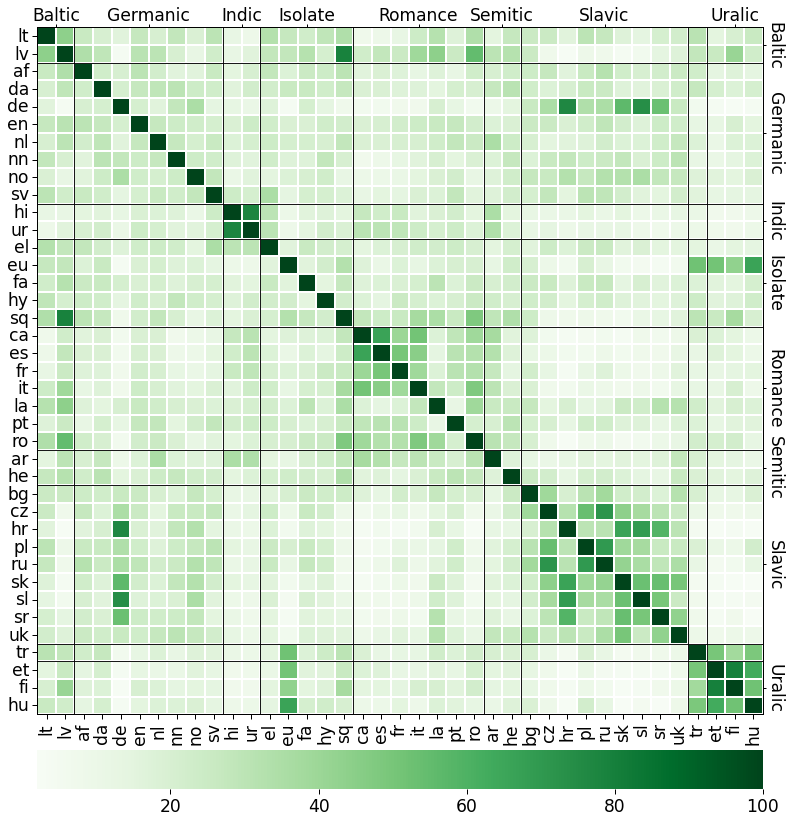

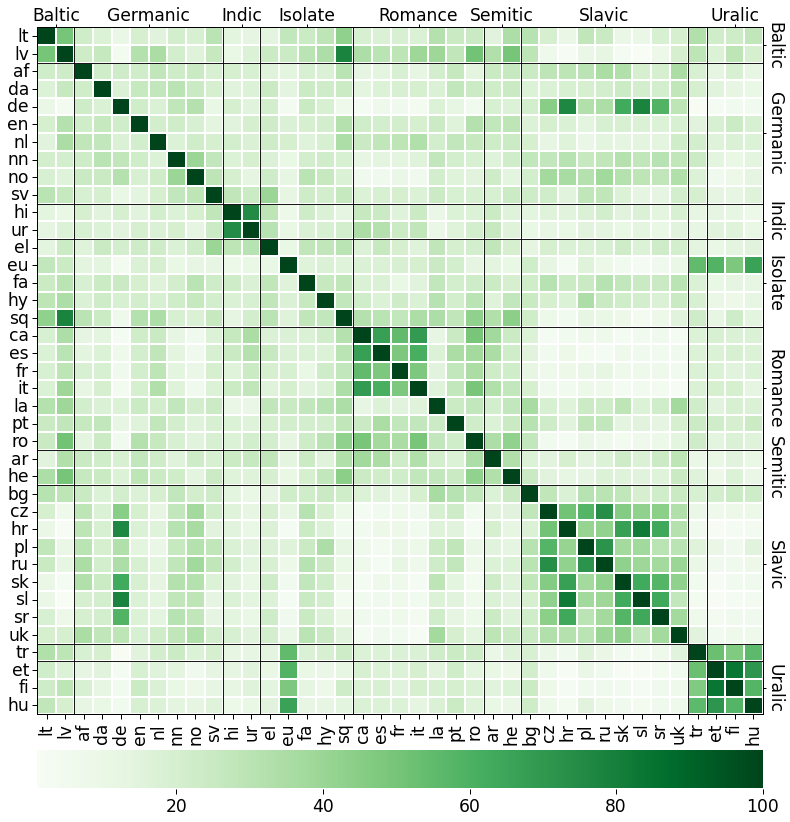

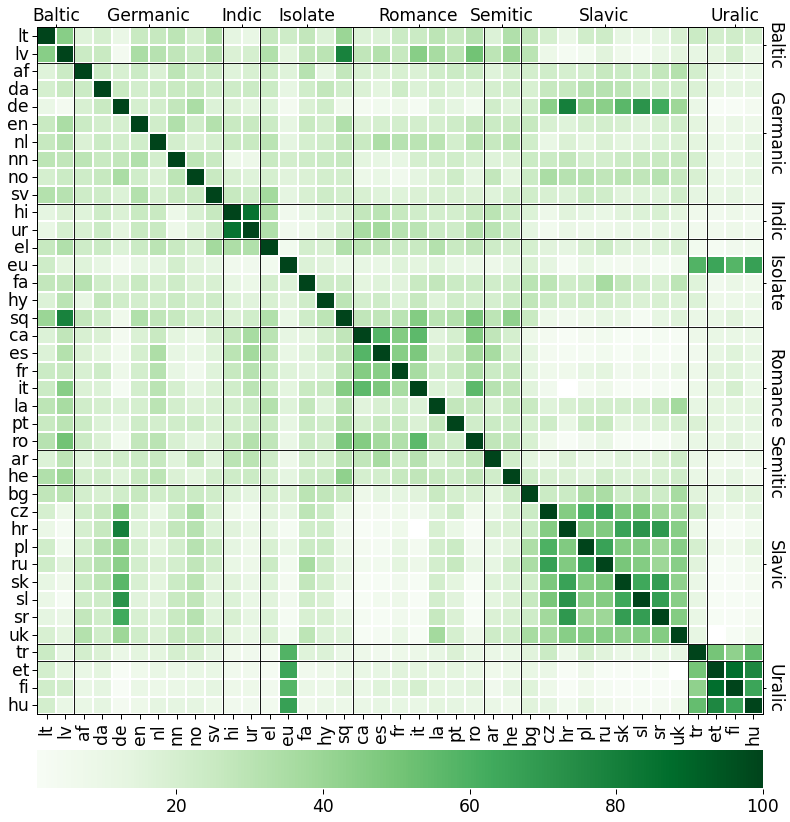

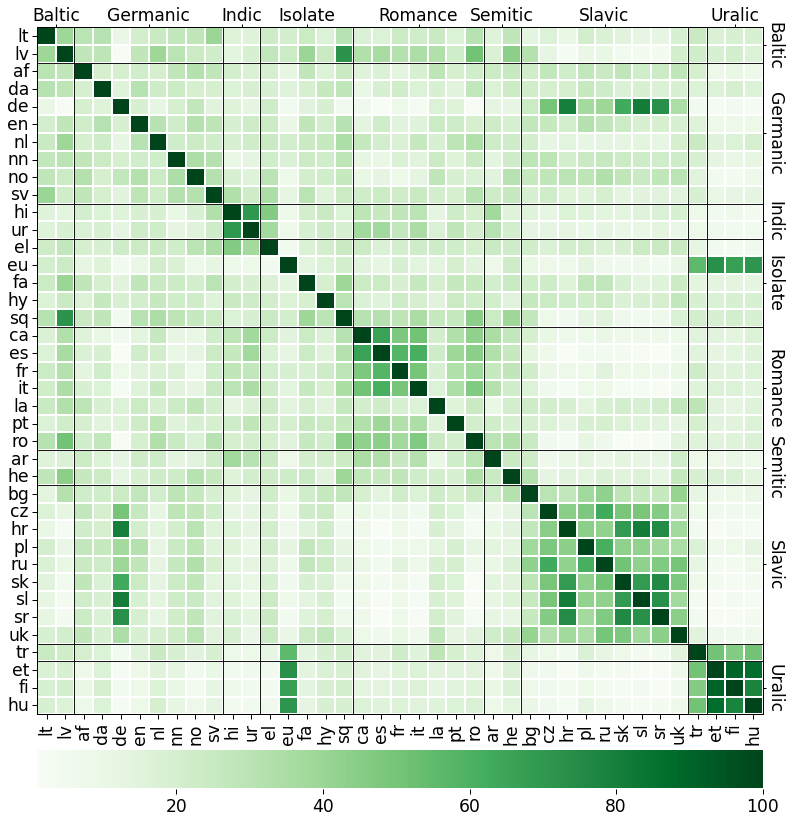

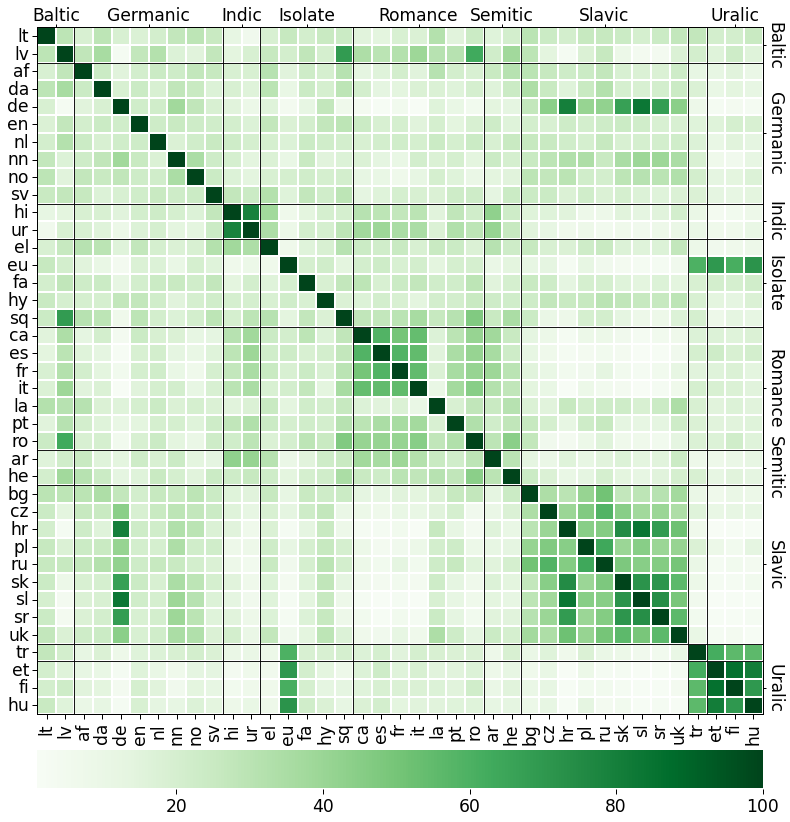

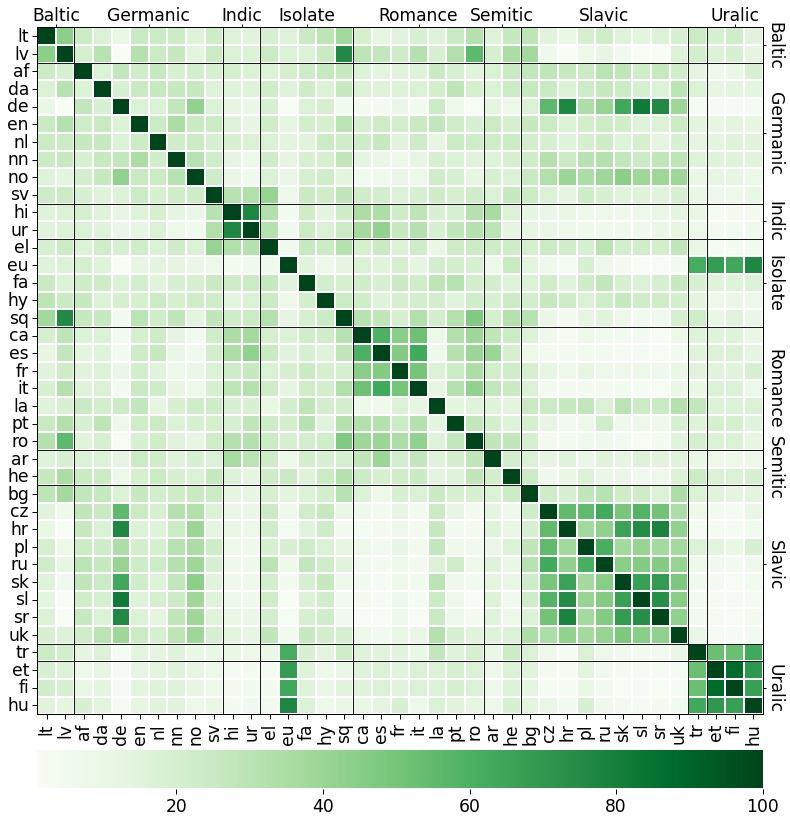

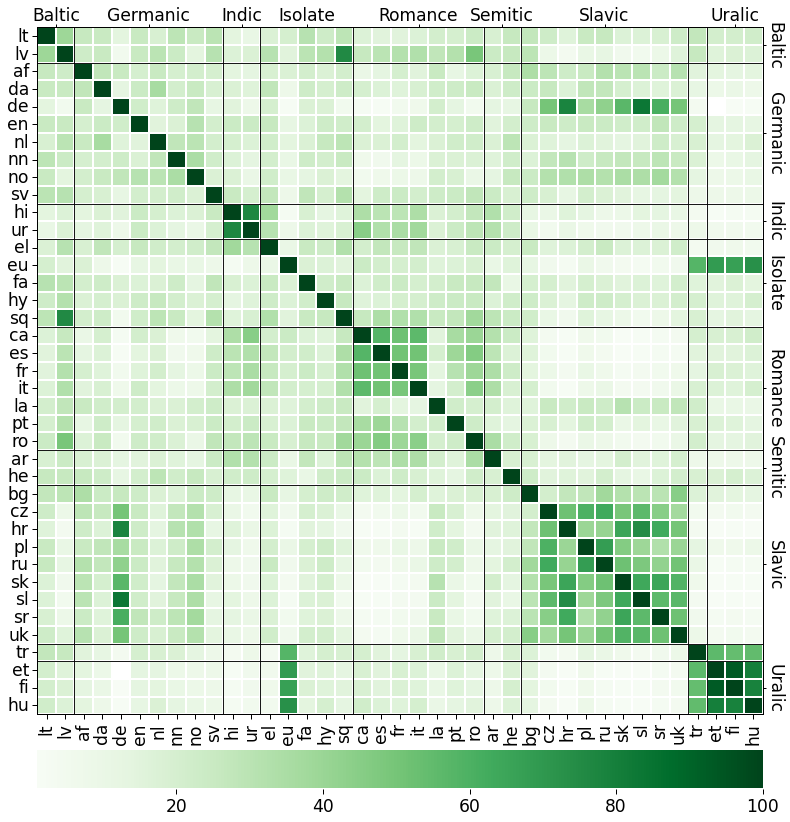

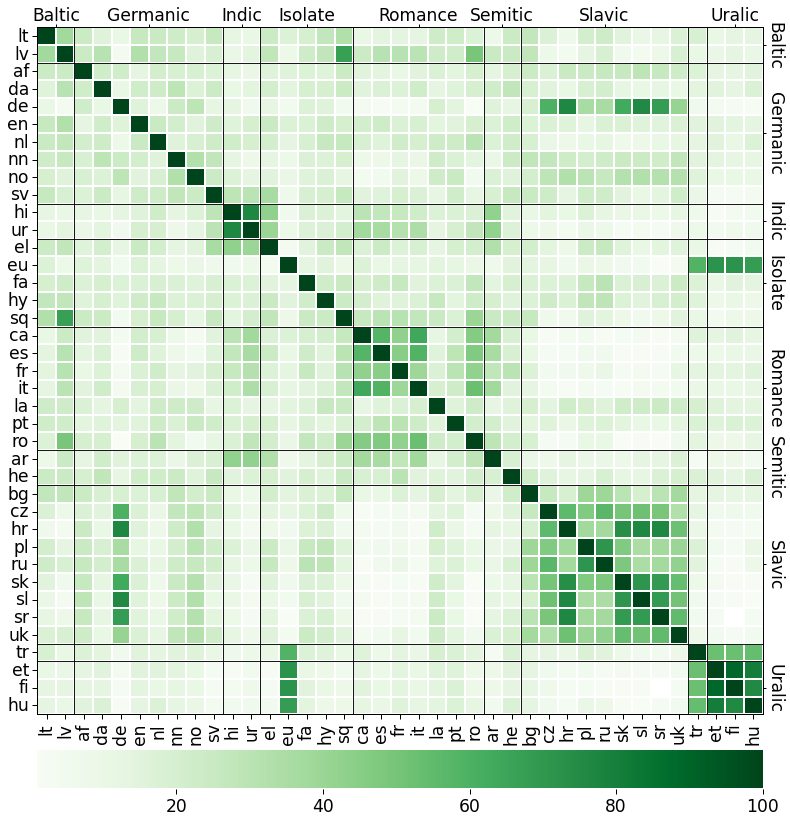

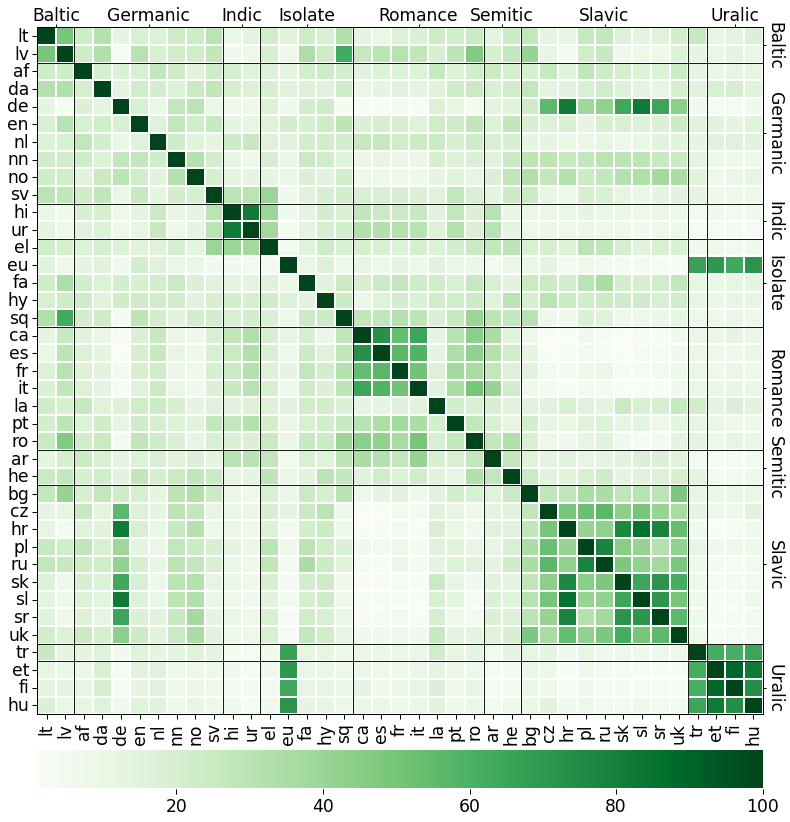

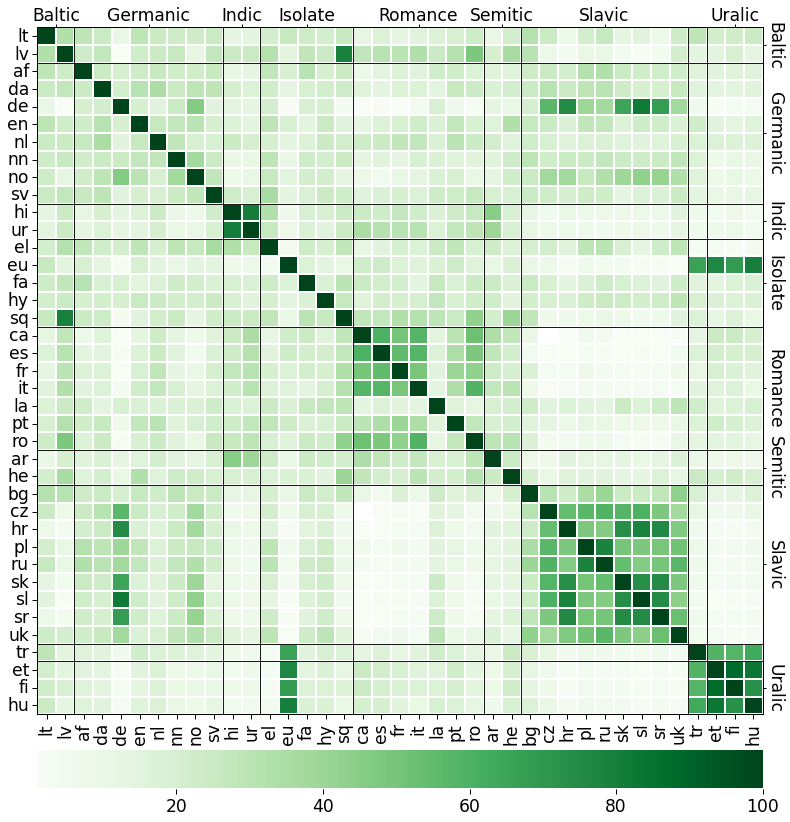

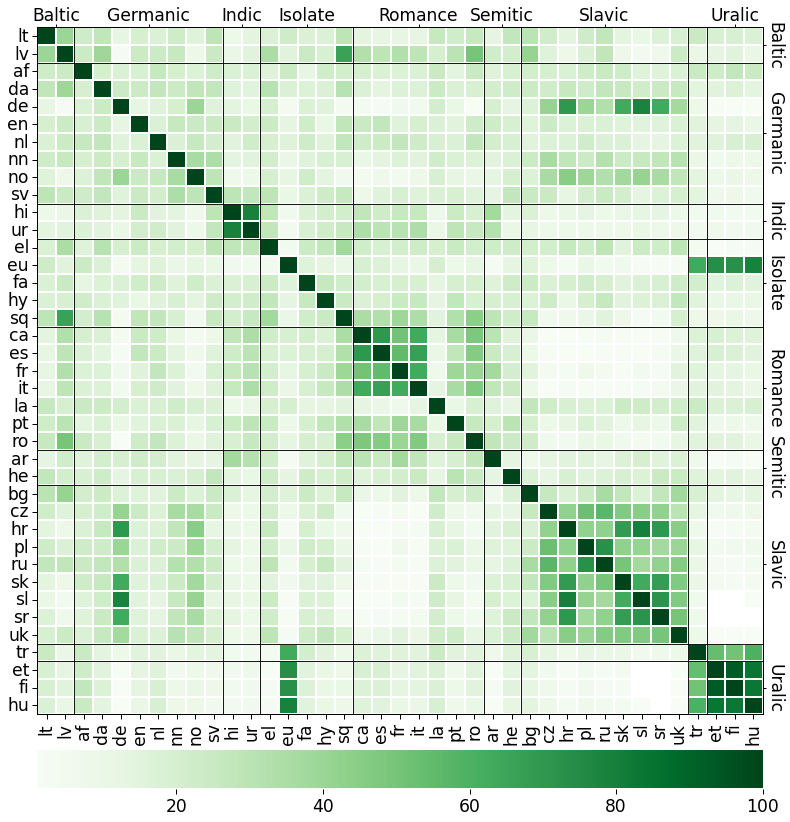

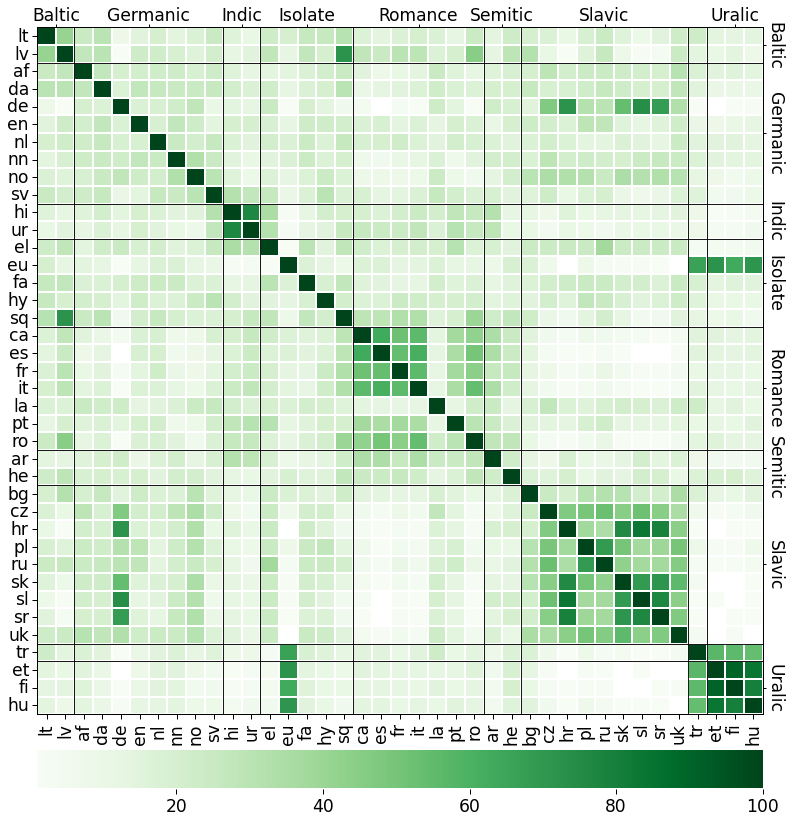

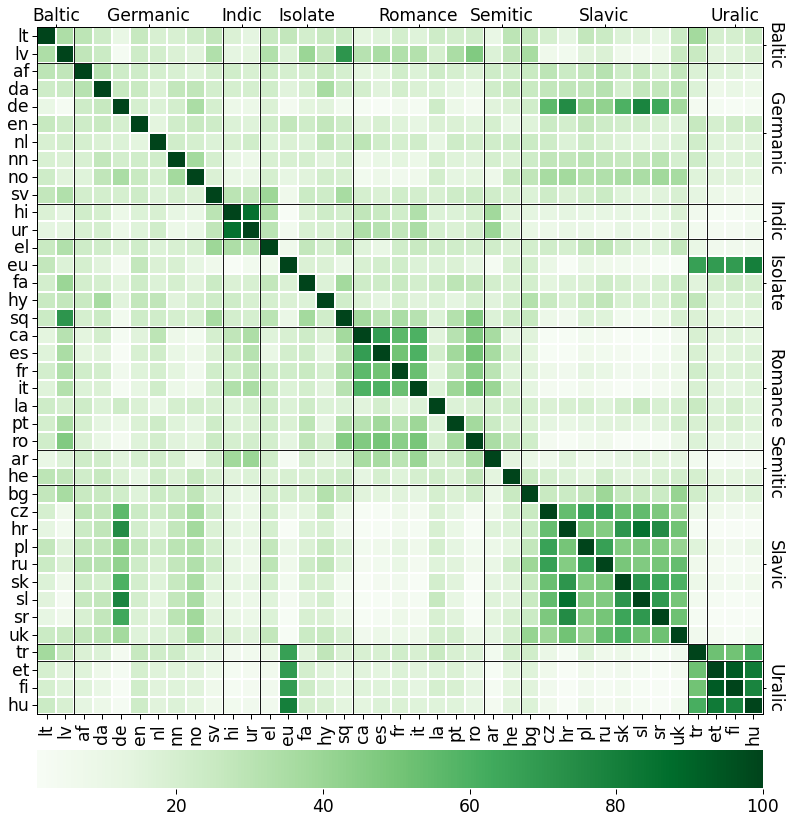

In [201]:
metric = 'chebyshev'
for perp in range(2, 15):
    cooc = defaultdict(lambda: defaultdict(int))
    print('perplexity:',perp)
    for _ in range(100):
        tsne = TSNE(
            perplexity=perp,
            metric="euclidean",
            n_jobs=100,
            random_state=np.random.randint(2, 90000),
            verbose=False,
        )
        X = test_effect.pivot_table(index='language', columns='task')
        value = np.random.normal(loc=X.mean(), scale=X.std(ddof=0), size=(39,402))
        stdfilled_df = pd.DataFrame(value, index=X.index, columns=X.columns)
        X = X.fillna(stdfilled_df)
        embedding_train = tsne.fit(X.to_numpy())

        K = np.random.randint(3, 9)
        labels = kmeans(embedding_train, n_clusters=K, metric=metric) #
        cl = pd.DataFrame({'language': X.index, 'cluster':labels})
        cl.groupby('cluster').language.apply(increase_cooc)

    with sns.plotting_context('paper', font_scale=1.95):
        grid_kws = {"height_ratios": (.9, .05), "hspace": .1}

        fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(13, 14))
        data = pd.DataFrame(cooc).loc[lang_order.language][lang_order.language]
        data.columns = [lang2code[c] for c in data.columns]
        data.index = [lang2code[c] for c in data.index]
        sns.heatmap(data, ax=ax, cmap='Greens', cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, linewidths=.1)
        for f in np.cumsum(family_size)[:-1]:
            ax.plot((f, f), (0, data.shape[0]), c='black', linewidth=.9)
            ax.plot((0, data.shape[1]), (f, f), c='black', linewidth=.9)
        for _, spine in ax.spines.items():
            spine.set_visible(True)
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax2 = ax.twiny()
        ax2.set_xticks(ticklocs)
        ax2.set_xticklabels(ticklabels)
        ax2.tick_params(axis='x', which='major', pad=0, length=3)
        ax2.xaxis.set_ticks_position('top')
        ax2.set_xlim(ax.get_xlim())

        ax3 = ax.twinx()
        ax3.set_yticks(ticklocs)
        ax3.set_yticklabels(ticklabels, va='center')
        ax3.tick_params(axis='y', rotation=-90, which='major', pad=0, length=3)
        ax3.yaxis.set_ticks_position('right')
        ax3.set_ylim(ax.get_ylim())

        fig.savefig(f"{figure_dir}/{model}_heatmap_langlang_cluster_kmeans_{metric}_over_tsne_perplexity_{perp}_cooc.pdf")